In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score


data = pd.read_csv('featured_data.csv')
data['date'] = pd.to_datetime(data['date'])



In [2]:
feature_columns = [
    "rsi_7", "rsi_9", "rsi_14", "rsi_21", "rsi_30", "rsi_50", "rsi_10", "rsi_60", 
    "kdjk", "kdjd", "kdjj", 
    "high_5_roc", "low_5_roc", "high_10_roc", "low_10_roc", "high_15_roc", "low_15_roc", "high_30_roc", "low_30_roc", 
    "close_5_roc", "close_10_roc", "close_15_roc",  "close_30_roc", 
    "macd", "macds", "macdh", "dma", 
    "eribull", "eribear", 
 "vix_Open", "day_of_week", "change"
]

timesteps = 30 
for col in feature_columns:
    for t in range(1, timesteps+1):
        data[f'{col}_t-{t}'] = data[col].shift(t)


data.dropna(inplace=True)

train = data[(data['date'] >= pd.Timestamp(year=1990, month=1, day=1)) & 
                    (data['date'] < pd.Timestamp(year=2022, month=1, day=1))]
test = data[data['date'] >= pd.Timestamp(year=2022, month=1, day=1)]


train.dropna(inplace=True)
test.dropna(inplace=True)


scaler = StandardScaler()
shifted_columns = [f'{col}_t-{t}' for col in feature_columns for t in range(1, timesteps + 1)]
all_shifted_columns = shifted_columns

X_train = scaler.fit_transform(train[all_shifted_columns])
X_test = scaler.transform(test[all_shifted_columns])


y_train = train['change'].values
y_test = test['change'].values



C:\Users\gjftn\AppData\Local\Temp\ipykernel_20984\2047143359.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[f'{col}_t-{t}'] = merged_data[col].shift(t)
C:\Users\gjftn\AppData\Local\Temp\ipykernel_20984\2047143359.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[f'{col}_t-{t}'] = merged_data[col].shift(t)
C:\Users\gjftn\AppData\Local\Temp\ipykernel_20984\2047143359.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which ha

In [3]:
total_features = len(all_shifted_columns)
print(total_features)
features_per_timestep = total_features // timesteps
X_train_reshaped = X_train.reshape((X_train.shape[0], timesteps, features_per_timestep))
X_test_reshaped = X_test.reshape((X_test.shape[0], timesteps, features_per_timestep))


960


In [4]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(timesteps, features_per_timestep)))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train_reshaped, y_train, epochs=100, batch_size=128, validation_split=0.1, verbose=1)

predictions = model.predict(X_test_reshaped)

Epoch 1/100
57/57 [==============================] - 5s 48ms/step - loss: 2.0793 - val_loss: 2.5630
Epoch 2/100
57/57 [==============================] - 2s 39ms/step - loss: 2.0659 - val_loss: 2.5354
Epoch 3/100
57/57 [==============================] - 2s 38ms/step - loss: 2.0568 - val_loss: 2.5497
Epoch 4/100
57/57 [==============================] - 2s 29ms/step - loss: 2.0551 - val_loss: 2.5379
Epoch 5/100
57/57 [==============================] - 2s 32ms/step - loss: 2.0439 - val_loss: 2.5898
Epoch 6/100
57/57 [==============================] - 2s 34ms/step - loss: 2.0372 - val_loss: 2.5730
Epoch 7/100
57/57 [==============================] - 2s 34ms/step - loss: 2.0135 - val_loss: 2.5918
Epoch 8/100
57/57 [==============================] - 2s 33ms/step - loss: 1.9996 - val_loss: 2.6022
Epoch 9/100
57/57 [==============================] - 2s 33ms/step - loss: 1.9549 - val_loss: 2.7330
Epoch 10/100
57/57 [==============================] - 2s 33ms/step - loss: 1.9311 - val_loss: 2.6991

In [5]:
from sklearn.metrics import mean_squared_error, r2_score
rmse = np.sqrt(mean_squared_error(y_test, predictions))


r2 = r2_score(y_test, predictions)

print(f"RMSE: {rmse}")
print(f"R^2 Score: {r2}")

RMSE: 2.290566815010276
R^2 Score: -0.8972066009743047


In [6]:
import pandas as pd


LSTM_predictions = predictions.flatten()


LSTM_results = pd.DataFrame({'True_Values': y_test, 'LSTM_Predictions': LSTM_predictions})


LSTM_results.to_csv('LSTM_predictions.csv', index=False)


C:\Users\gjftn\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\gjftn\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


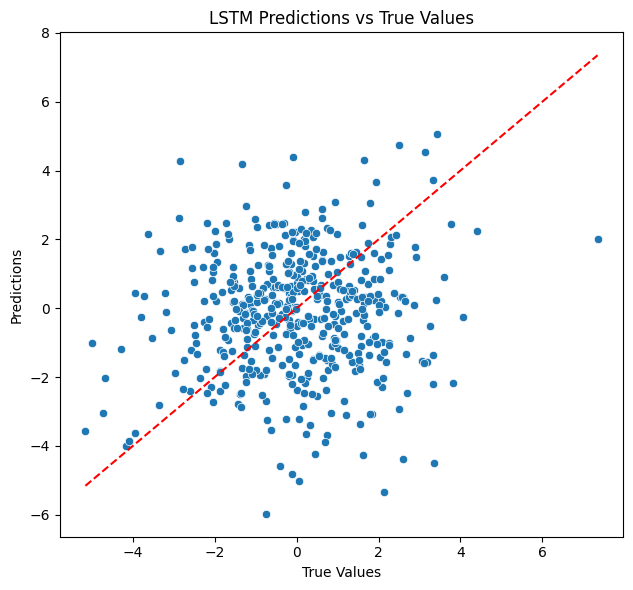

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


LSTM_results = pd.DataFrame({'True_Values': y_test, 'LSTM_Predictions': LSTM_predictions})


plt.figure(figsize=(18, 6))


plt.subplot(1, 3, 1) 
sns.scatterplot(x='True_Values', y='LSTM_Predictions', data=LSTM_results)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('LSTM Predictions vs True Values')
plt.xlabel('True Values')
plt.ylabel('Predictions')

plt.tight_layout()
plt.show()
